In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from joblib import Parallel, delayed
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
from sklearn.cluster import DBSCAN
import time
plt.rcParams["font.family"] = "Times New Roman"
from GeoRefTool import *
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from BfTableGenerator import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
def count(TSAv):
    temp_count = 0
    apear_ind = []
    counts = []
    for i in range(len(TSAv)):
        if (TSAv[i] == True):
            temp_count += 1
        else:
            if (i > 0) & (TSAv[i - 1] == True):
                apear_ind.append(i - temp_count)
                counts.append(temp_count)
                temp_count = 0
                counts.append(0)
            else:
                counts.append(0)
        if (i == len(TSAv) - 1) & (temp_count != 0):
            apear_ind.append(i - temp_count + 1)
            counts.append(temp_count)
    counts = np.array(counts)
    counts = counts[counts > 0]
    return np.array(counts), np.array(apear_ind)

In [3]:
def gen_xyz(dis,i,j):
    longitudes = theta[i]*np.pi / 180
    latitudes = azimuths[j] * np.pi / 180 
    hypotenuses = dis * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = dis * np.sin(longitudes)
    return np.array([X,Y,Z])

In [4]:
db = Raster_DBSCAN(window_size=[5,13],eps = 1.5,min_samples = 12,Td_map_szie = [32,1800])
dbscan = DBSCAN(eps = 1, min_samples = 20)

In [53]:
thred_map = np.load(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy')


In [7]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps\2022-1-22-11-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)
# thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.08,bck_n = 3 )
thred_map = np.load(r'D:\LiDAR_Data\MidTown\Larue\bck_larue.npy')
thred_map = thred_map.max(axis = 0)
aggregated_Labeling_map = []
for i in tqdm(range(aggregated_map.shape[0])):
    Td_map = aggregated_map[i]
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 1.5).any(axis = 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    aggregated_Labeling_map.append(Labeling_map)
aggregated_Labeling_map = np.array(aggregated_Labeling_map)
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        foreground_ind = aggregated_Labeling_map[:,i,j] != -1
        if foreground_ind.any(): # foreground
            dis_values = aggregated_map[foreground_ind,i,j]
            labels = dbscan.fit_predict(dis_values.reshape(-1,1))
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[1:]
            if len(unique_labels) >= 1: 
                for l in unique_labels:
                    dis = np.mean(dis_values[labels == l])
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = (labels == l).sum()/len(foreground_ind)
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3,
                                         ransac_n=10,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

  0%|                                                                                        | 0/17847 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

24.884
1309


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

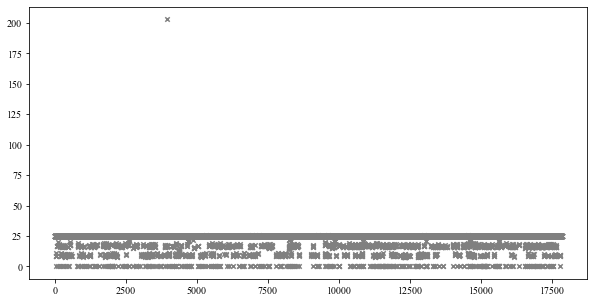

In [12]:
laser_id = 4
azimuth_channel = 1309
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)

# plt.xlim(2000,2400)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

## Large Bck Generator

In [48]:
def get_thred(temp,N = 10,d_thred = 0.1,bck_n = 3):
    temp = temp.copy()
    total_sample = len(temp)
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        ind = np.abs(temp - sample) < 0.3
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
        
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    
    if len(bck_ds_) <= bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-1 * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

In [49]:
def gen_bckmap(aggregated_maps, N, d_thred, bck_n):
    thred_map = np.zeros((bck_n,32,1800))
    for i in tqdm(range(thred_map.shape[1])):
        for j in range(thred_map.shape[2]):
            thred_map[:,i,j] = get_thred(aggregated_maps[:,i,j],N = N,d_thred = d_thred,bck_n = bck_n)
    return thred_map

In [50]:
f_path = r'D:\LiDAR_Data\MidTown\Larue\Agg'
agg_dirs = np.array(os.listdir(f_path))
hours = [eval(f.split('-')[3]) for f in agg_dirs]
agg_dirs = agg_dirs[np.argsort(hours)]
aggregated_maps = []
for f in tqdm(agg_dirs):
    aggregated_map = np.load(os.path.join(f_path,f))
    aggregated_maps.append(aggregated_map)
aggregated_maps = np.concatenate(aggregated_maps)

In [51]:
aggregated_maps = []
for f in tqdm(agg_dirs):
    aggregated_map = np.load(os.path.join(f_path,f))
    aggregated_maps.append(aggregated_map)
aggregated_maps = np.concatenate(aggregated_maps)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:43<00:00,  6.82s/it]


In [17]:
thred_map = gen_bckmap(aggregated_maps, N = 20,d_thred = 0.12,bck_n = 5)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [04:26<00:00,  8.34s/it]


In [ ]:
np.array([[15,496],[11,537],[14,564]])

In [18]:
np.save(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\bck_larue.npy',thred_map)

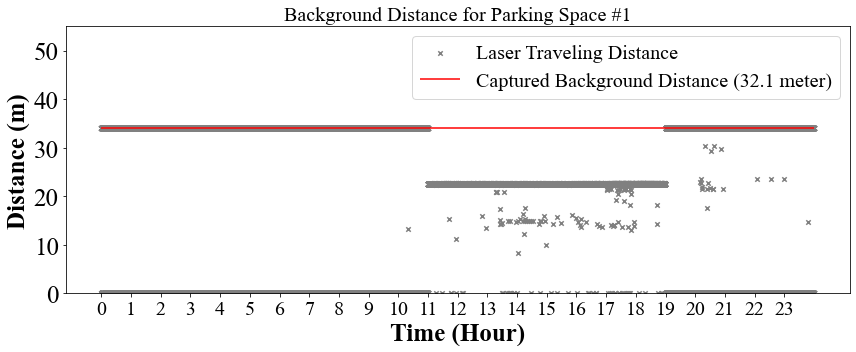

In [78]:
laser_id = 15
azimuth_channel = 496
temp = aggregated_maps[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(12,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
plt.hlines(thred.max(),0,aggregated_maps.shape[0],color = 'r', label = 'Captured Background Distance (32.1 meter)')
plt.yticks(fontsize = 25)
plt.xticks(np.arange(0,48000,2000), np.arange(24),fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (Hour)',fontsize = 25, fontweight = 'bold')
plt.ylim(0,55)
plt.title('Background Distance for Parking Space #1',fontsize = 20)
plt.legend(fontsize = 20)
plt.tight_layout()

plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\CapN1.tif',dpi = 300)
plt.show()

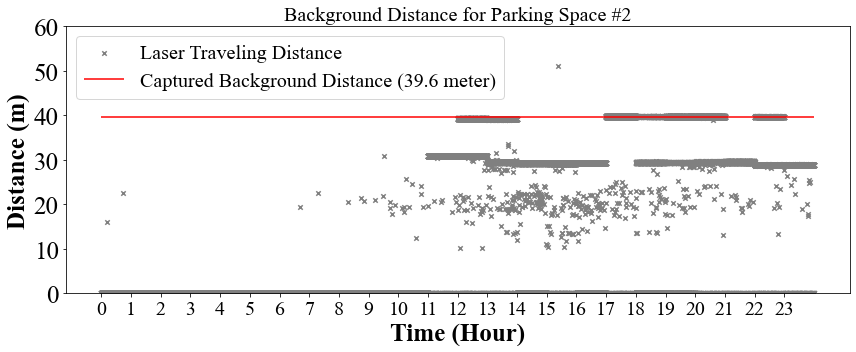

In [79]:
laser_id = 11
azimuth_channel = 537
temp = aggregated_maps[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(12,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
plt.hlines(thred.max(),0,aggregated_maps.shape[0],color = 'r', label = 'Captured Background Distance (39.6 meter)')
plt.yticks(fontsize = 25)
plt.xticks(np.arange(0,48000,2000), np.arange(24),fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (Hour)',fontsize = 25, fontweight = 'bold')
plt.ylim(0,60)
plt.title('Background Distance for Parking Space #2',fontsize = 20)
plt.legend(fontsize = 20)
plt.tight_layout()

plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\CapN2.tif',dpi = 300)
plt.show()

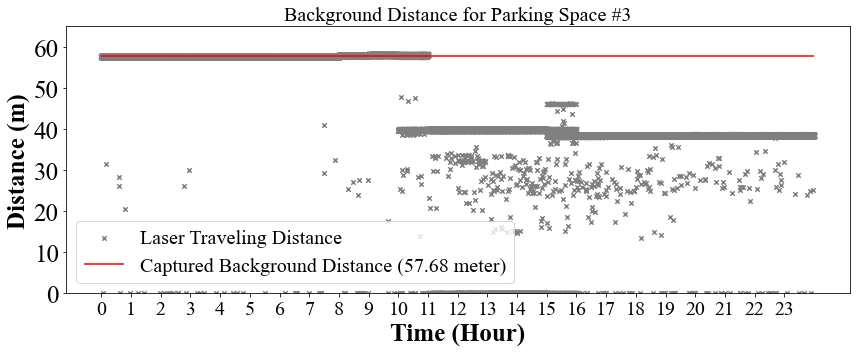

In [80]:
laser_id = 14
azimuth_channel = 564
temp = aggregated_maps[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(12,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
plt.hlines(thred.max(),0,aggregated_maps.shape[0],color = 'r', label = 'Captured Background Distance (57.68 meter)')
plt.yticks(fontsize = 25)
plt.xticks(np.arange(0,48000,2000), np.arange(24),fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (Hour)',fontsize = 25, fontweight = 'bold')
plt.ylim(0,65)
plt.title('Background Distance for Parking Space #3',fontsize = 20)
plt.legend(fontsize = 20)
plt.tight_layout()

plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\CapN3.tif',dpi = 300)
plt.show()

## Parking Test

In [5]:
thred_map = np.load(r'D:\LiDAR_Data\MidTown\Larue\bck_larue.npy')

In [6]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Larue\PaperPcaps_22\2022-1-22-12-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)

100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [12:01<00:00, 24.95it/s]


In [8]:
temp = aggregated_map[17997].copy()
label_map = np.zeros_like(temp)
label_map[0:30,110:120] = 1
pcd = get_pcd_colored(temp,label_map.astype(int))
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_1')

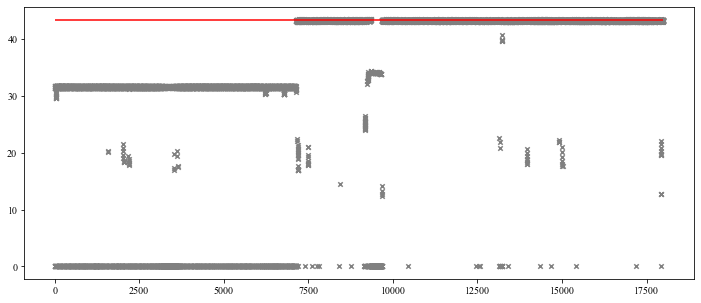

In [25]:
laser_id = 14
azimuth_channel = 530
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
thred = thred_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(12,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
plt.hlines(thred.max(),0,aggregated_map.shape[0],color = 'r', label = 'Captured Background Distance (57.68 meter)')


In [80]:
Laser_ID = np.arange(57600).reshape((32,1800))

In [159]:
laser_id = 1
azimuth_channel = 590

0
7100
---
9500
100
---


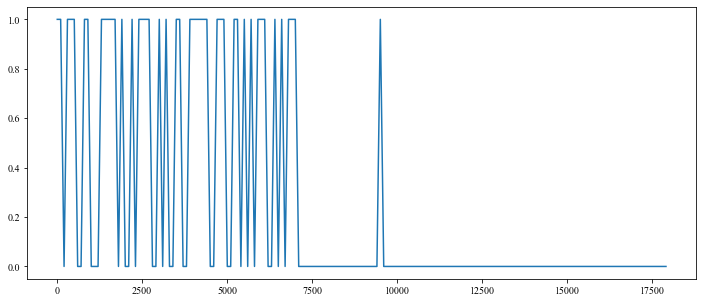

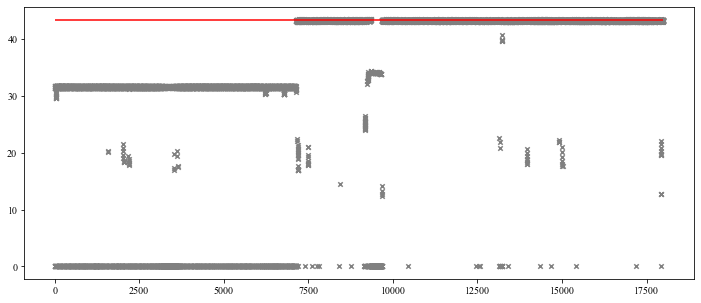

In [347]:
# %%timeit
laser_id = 14
azimuth_channel = 530
window_size = 100 # 900 frames -> 9 secs 
sampled_inds = np.arange(0, len(temp), window_size)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
bck_dis = thred_map[:,laser_id,azimuth_channel].max()

Parking_ind = []
Sampled_ind = []
for i in range(1,len(sampled_inds)):
    cur_dis = temp[sampled_inds[i]]
    if cur_dis == 0:
        Parking_ind.append(False)
    else:
        if (bck_dis - cur_dis) > 1.5:
            past_dis = temp[sampled_inds[i] - window_size:sampled_inds[i]]
            past_dis = past_dis[past_dis != 0]
            if len(past_dis) == 0:
                Parking_ind.append(False)
            else:
                if np.abs(cur_dis - np.median(past_dis)) < 1:
                    Parking_ind.append(True)
                else:
                    Parking_ind.append(False)
        else:
            Parking_ind.append(False)
    Sampled_ind.append(i)

Parking_ind = np.array([Parking_ind[0]] + Parking_ind)
plt.figure(figsize=(12,5))
plt.plot(sampled_inds,Parking_ind)
counts,appears = count(~Parking_ind)
if len(counts) > 0:
    for i,a in enumerate(appears):
        if counts[i] < 6: # if the parking is less than 60 sec will not be recorded
            Parking_ind[a: a + counts[i]] = True
    counts,appears = count(Parking_ind)

    for i,a in enumerate(appears):
        c = counts[i]
        dis = np.median(temp[sampled_inds[a] : sampled_inds[a + c]])
#         Laser_IDs.append(Laser_ID[laser_id,azimuth_channel])
        XYZ = gen_xyz(dis,laser_id,azimuth_channel)
#         XYZs.append(XYZ)
        print(sampled_inds[a])
#         Start.append(sampled_inds[a])
        print(c*window_size)
        print('---')
#         Duration.append(c * window_size)

thred = thred_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(12,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
plt.hlines(thred.max(),0,aggregated_map.shape[0],color = 'r', label = 'Captured Background Distance (57.68 meter)')
plt.show()
# plt.figure(figsize=(12,5))
# plt.plot(sampled_inds,Parking_ind)

In [385]:
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)

In [ ]:
window_size = 100 # 900 frames -> 9 secs 
sampled_inds = np.arange(0, len(temp), window_size)

In [441]:
def gen_Parking_info(aggregated_map,T,f_name):
    
    XYZs = []
    dises = []
    Laser_IDs = []
    End = []
    Start = [] 
    for laser_id in range(aggregated_map.shape[1]):
        for azimuth_channel in range(aggregated_map.shape[2]):

            temp = aggregated_map[:,laser_id,azimuth_channel].copy()
            bck_dis = thred_map[:,laser_id,azimuth_channel].max()

            Parking_ind = []
            Sampled_ind = []
            for i in range(1,len(sampled_inds)):
                cur_dis = temp[sampled_inds[i]]
                if cur_dis == 0:
                    Parking_ind.append(False)
                else:
                    if (bck_dis - cur_dis) > 1.5:
                        past_dis = temp[sampled_inds[i] - window_size:sampled_inds[i]]
                        past_dis = past_dis[past_dis != 0]
                        if len(past_dis) == 0:
                            Parking_ind.append(False)
                        else:
                            if np.abs(cur_dis - np.median(past_dis)) < 1:
                                Parking_ind.append(True)
                            else:
                                Parking_ind.append(False)
                    else:
                        Parking_ind.append(False)
                Sampled_ind.append(i)

            Parking_ind = np.array([Parking_ind[0]] + Parking_ind)
            counts,appears = count(~Parking_ind)
            if len(counts) > 0:
                for i,a in enumerate(appears):
                    if counts[i] < 6: # if the parking is less than 60 sec will not be recorded
                        Parking_ind[a: a + counts[i]] = True
                counts,appears = count(Parking_ind)

                for i,a in enumerate(appears):
                    c = counts[i]
                    dis = temp[sampled_inds[a]]
                    Laser_IDs.append(Laser_ID[laser_id,azimuth_channel])
                    XYZ = gen_xyz(dis,laser_id,azimuth_channel)
                    XYZs.append(XYZ)
                    Start.append(sampled_inds[a])
                    End.append(sampled_inds[a + c - 1])
    XYZs = np.array(XYZs)
    Laser_IDs = np.array(Laser_IDs).reshape(-1,1)
    Start = np.array(Start).reshape(-1,1)
    End = np.array(End).reshape(-1,1)
    LLH = convert_LLH(XYZs.astype(np.float64),T)
    ts_arr = f_name.split('.')[0].split('-')
    f_name = '2022-1-22-12-0-0.pcap'
    ts_arr = f_name.split('.')[0].split('-')
    Day = pd.Timestamp(eval(ts_arr[0]),eval(ts_arr[1]),eval(ts_arr[2]),0,0,0)
    try:
        sec = eval(ts_arr[5])
    except:
        sec = eval(ts_arr[5][:-1])
    f_time = pd.Timestamp(eval(ts_arr[0]),eval(ts_arr[1]),eval(ts_arr[2]),eval(ts_arr[3]),eval(ts_arr[4]),sec)
    Start_ts = f_time + pd.Series([pd.Timedelta(seconds = Start[i][0]/10) for i in range(len(Start))])
    End_ts = f_time + pd.Series([pd.Timedelta(seconds = End[i][0]/10) for i in range(len(End))])
    
    Result_info = np.concatenate([Laser_IDs,LLH,XYZs,Start,End],axis = 1)
    Result_info = pd.DataFrame(Result_info, columns = ['LaserBeamID','Lon','Lat','Elev','X','Y','Z','Start_frame','End_frame'])
    Result_info.insert(column= 'End_ts', value = End_ts, loc = 0)
    Result_info.insert(column= 'Start_ts', value = Start_ts, loc = 0)
    return Result_info

In [438]:
f_name = '2022-1-22-12-0-0.pcap'


In [439]:
Result_info = gen_Parking_info(aggregated_map,T,f_name)

In [440]:
Result_info

,End_ts,Start_ts,LaserBeamID,Lon,Lat,Elev,X,Y,Z,Start_frame,End_frame
0,2022-01-22 12:15:10,2022-01-22 12:15:10,714.0,-119.808295,39.516501,1318.012322,1.926602,-2.538205,-1.485926,9100.0,9100.0
1,2022-01-22 12:15:10,2022-01-22 12:15:10,715.0,-119.808298,39.516500,1318.012324,1.804281,-2.394362,-1.398021,9100.0,9100.0
2,2022-01-22 12:19:20,2022-01-22 12:19:20,2146.0,-119.808326,39.516528,1318.012349,3.157964,1.199598,-0.945670,11600.0,11600.0
3,2022-01-22 12:29:50,2022-01-22 12:00:00,2390.0,-119.808269,39.516526,1318.012333,5.492681,-2.920510,-1.741457,0.0,17900.0
4,2022-01-22 12:09:10,2022-01-22 12:00:00,2397.0,-119.808261,39.516528,1318.012330,6.003604,-3.382857,-1.929081,0.0,5500.0
...,...,...,...,...,...,...,...,...,...,...,...
21921,2022-01-22 12:13:40,2022-01-22 12:13:20,57513.0,-119.808828,39.516590,1318.012835,-12.284265,39.199137,11.007056,8000.0,8200.0
21922,2022-01-22 12:24:00,2022-01-22 12:23:40,57513.0,-119.808808,39.516586,1318.012811,-11.803616,37.665386,10.576381,14200.0,14400.0
21923,2022-01-22 12:26:50,2022-01-22 12:26:50,57513.0,-119.808816,39.516588,1318.012820,-12.001191,38.295846,10.753414,16100.0,16100.0
21924,2022-01-22 12:06:40,2022-01-22 12:05:40,57526.0,-119.808814,39.516604,1318.012833,-10.318736,39.054848,10.823812,3400.0,4000.0


In [58]:
Parking_coord = np.array([[15,496],[11,537],[14,564]])

In [93]:
row_ind,col_ind = [],[]
occupancies = []
starts = []
ends = []
points = []
laser_id = 14
azimuth_id = 564

temp = aggregated_map[:,laser_id,azimuth_id].copy()
thred = thred_map[:,laser_id,azimuth_id]
thred_max = thred.max()
bck_inds = ((np.abs((temp - thred_max)) < 2))
temp[bck_inds] = 0
time_window = 600
parking_label  = []
for i in range(time_window,len(temp)):
    past_dis = temp[i - time_window:i]
    past_dis = past_dis[past_dis!=0]
    if len(past_dis) == 0:
        parking_label.append(False)
    else:
        if np.abs(temp[i] - np.median(past_dis)) < 0.6:
            parking_label.append(True)
        else:
            parking_label.append(False)
parking_label = time_window*[parking_label[0]] + parking_label
parking_label = np.array(parking_label)
counts,appears = count(~parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = True
counts,appears = count(parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = False
counts,appears = count(parking_label) 

for l,a in enumerate(appears):
    parking_dis = temp[a:a+counts[l]]
    parking_dis = parking_dis[parking_dis!=0]
    dis =  np.median(parking_dis)
    XYZ = gen_xyz(dis,laser_id,azimuth_id)
    points.append(XYZ)
    occupancy = counts[l]
    occupancies.append(occupancy)
    row_ind.append(laser_id)
    col_ind.append(azimuth_id)
    starts.append(a)
    ends.append(a + counts[l])
    
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
starts = np.array(starts)
ends = np.array(ends)
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),starts.reshape(-1,1),ends.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Starts','Ends','LaserID','AzimuthID'])

resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

AxisError: axis 1 is out of bounds for array of dimension 1

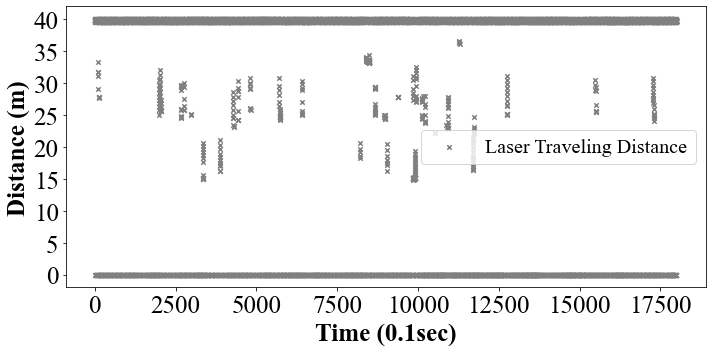

In [90]:
laser_id = 14
azimuth_channel = 564
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
# plt.ylim(0.1,40)
plt.legend(fontsize = '20')
plt.tight_layout()
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\PixelProcess.tif',dpi = 300)
plt.show()

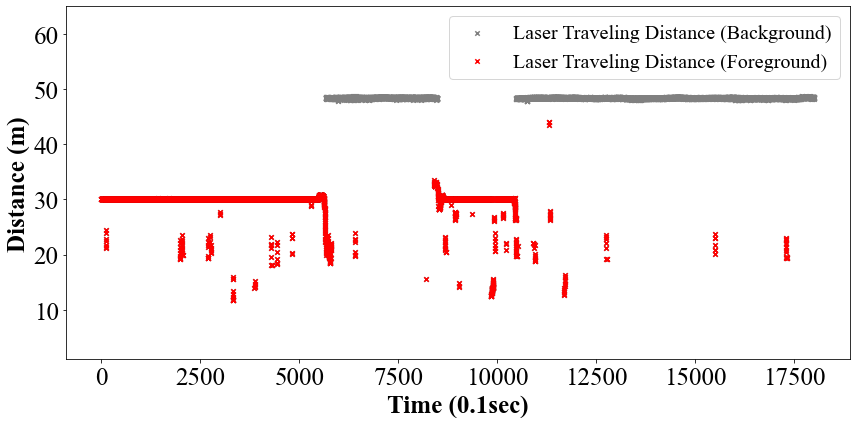

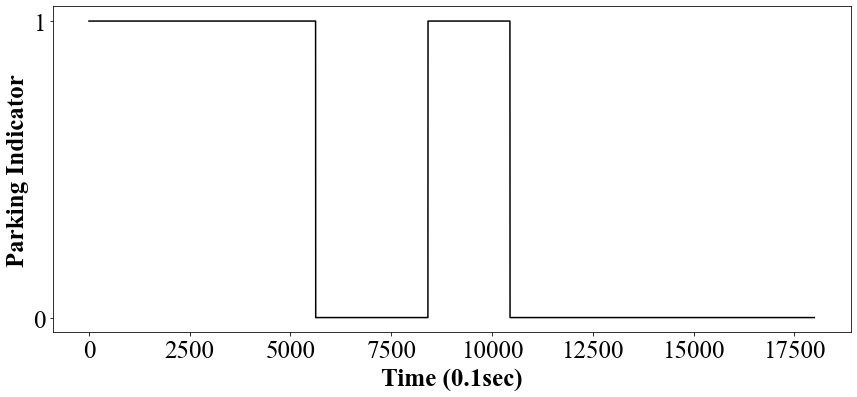

In [77]:
laser_id = 13
azimuth_channel = 539
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(12,6))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance (Background)", c = 'gray')

thred = thred_map[:,laser_id,azimuth_channel]
thred_max = thred.max()
bck_inds = ((np.abs((temp - thred_max)) < 2))
temp[bck_inds] = 0
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance (Foreground)", c = 'r')
time_window = 600
parking_label  = []
for i in range(time_window,len(temp)):
    past_dis = temp[i - time_window:i]
    past_dis = past_dis[past_dis!=0]
    if len(past_dis) == 0:
        parking_label.append(False)
    else:
        if np.abs(temp[i] - np.median(past_dis)) < 0.5:
            parking_label.append(True)
        else:
            parking_label.append(False)
            
parking_label = time_window*[parking_label[0]] + parking_label

plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.ylim(1,65)
plt.legend(fontsize = '20')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\ForegroundBackground.tif',dpi = 300)
plt.show()
plt.figure(figsize=(14.3,6))
parking_label = np.array(parking_label)
counts,appears = count(~parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = True
counts,appears = count(parking_label)
for i,a in enumerate(appears):
    c = counts[i]
    if c < time_window:
        parking_label[a:a+c+1] = False
counts,appears = count(parking_label)        

plt.plot(parking_label, c = 'black')
plt.yticks([0,1],fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylabel('Parking Indicator',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\Parking Indicator.tif',dpi = 300)

plt.show()

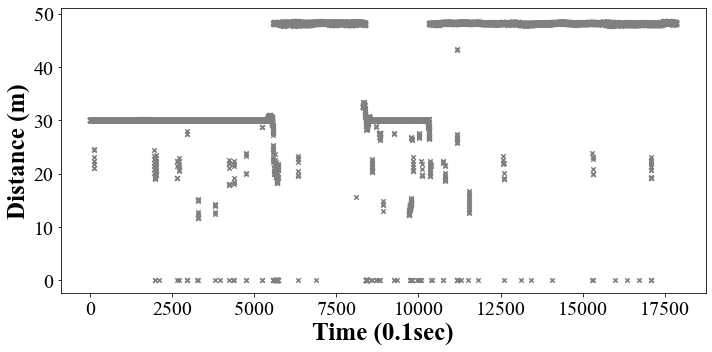

In [19]:
laser_id = 13
azimuth_channel = 538
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
# plt.ylim(19.2,19.27)

plt.show()

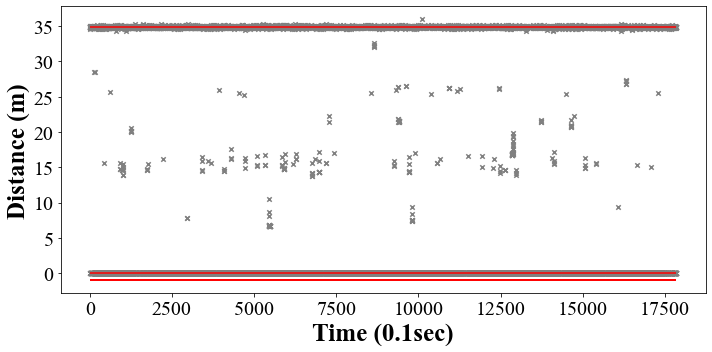

In [17]:
laser_id = 11
azimuth_channel = 1344
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
# plt.ylim(34.5,36)

plt.show()

In [36]:
aggregated_Labeling_map = []
for i in tqdm(range(aggregated_map.shape[0])):
    Td_map = aggregated_map[i]
    Foreground_map = (~(np.abs(Td_map - thred_map) <= 1.5))&(Td_map > 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    aggregated_Labeling_map.append(Labeling_map)
aggregated_Labeling_map = np.array(aggregated_Labeling_map)
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        foreground_ind = aggregated_Labeling_map[:,i,j] != -1
        if foreground_ind.any(): # foreground
            dis_values = aggregated_map[foreground_ind,i,j]
            labels = dbscan.fit_predict(dis_values.reshape(-1,1))
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[1:]
            if len(unique_labels) >= 1: 
                for l in unique_labels:
                    dis = np.mean(dis_values[labels == l])
                    XYZ = gen_xyz(dis,i,j)
                    points.append(XYZ)
                    occupancy = (labels == l).sum()/len(foreground_ind)
                    occupancies.append(occupancy)
                    row_ind.append(i)
                    col_ind.append(j)
points = np.array(points)
occupancies = np.array(occupancies)
col_ind = np.array(col_ind)
row_ind = np.array(row_ind)
pcd = get_pcd_uncolored(aggregated_map[1354])
plane_model, inliers = pcd.segment_plane(distance_threshold=0.3,
                                         ransac_n=10,
                                         num_iterations=1000)
height = np.abs(plane_model[0] * points[:,0] + plane_model[1] * points[:,1] + plane_model[2] * points[:,2] + plane_model[3]) / (np.sqrt(plane_model[0]**2 + plane_model[1]**2 +plane_model[2]**2))
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,occupancies.reshape(-1,1),height.reshape(-1,1),row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','Occupancy','Height','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\occ.csv',index = False)

 38%|████████████████████████████▉                                                | 12/32 [1:21:34<2:15:58, 407.90s/it]


KeyboardInterrupt: 

In [12]:
temp = aggregated_map[12]
points = []
occupancies = []
row_ind = []
col_ind = []
for i in tqdm(range(32)):
    for j in range(1800):
        dis = temp[i,j]
        XYZ = gen_xyz(dis,i,j)
        points.append(XYZ)
        row_ind.append(i)
        col_ind.append(j)
points = np.array(points)
row_ind = np.array(row_ind)
col_ind = np.array(col_ind)
input_path = r'D:\LiDAR_Data\MidTown\Larue\Calibration'
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset * 3.2808
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

T = generate_T(ref_LLH,ref_xyz)
LLH = convert_LLH(points.astype(np.float64),T)
resultGram = pd.DataFrame(np.concatenate([points,LLH,row_ind.reshape(-1,1),col_ind.reshape(-1,1)],axis =1 ),columns=['X','Y','Z','Longitude','Latitude','Elevation','LaserID','AzimuthID'])
resultGram.to_csv(r'D:\LiDAR_Data\MidTown\Larue\reference.csv',index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 93.06it/s]


In [56]:
temp = aggregated_map[12].copy()
label_map = np.zeros_like(temp)
label_map[11:12,1340:1343] = 1
pcd = get_pcd_colored(temp,label_map.astype(int))
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_17')

In [32]:
thred_map = thred_map.max(axis = 0)

In [35]:
Td_map = aggregated_map[2]
Foreground_map = (~(np.abs(Td_map - thred_map) <= 1))&(Td_map > 0)
pcd = get_pcd_colored(Td_map,Foreground_map.astype('int'))
draw(pcd)

WebVisualizer(window_uid='window_4')

0.0
1344


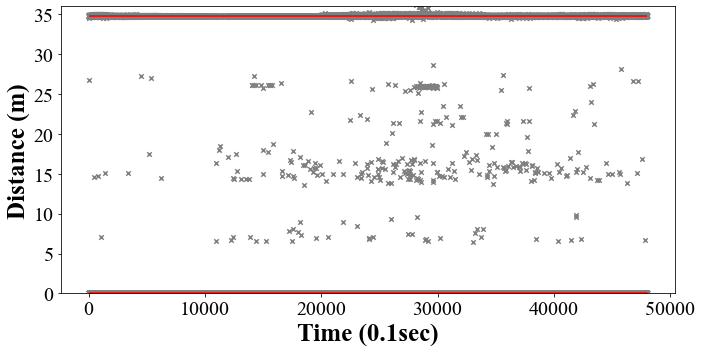

In [64]:
laser_id = 11
azimuth_channel = 1344
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_maps[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_maps.shape[0],color = 'r')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,36)

# plt.xlim(2000,2400)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

## Parking Analysis

In [178]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\Larue22'
dir_list = os.listdir(f_path)
time_list = []
parking_events_list = []
for i in range(3):
    time = []
    parking_events = []
    for p in dir_list:
        t = p.split('.')[0]
        Year,Month,Day,Hour,Minitue,Second = np.array(t.split('-'))
        Second,Parking_ind = Second.split('_')
        Parking_ind = eval(Parking_ind)
        if Parking_ind == i:
            time.append(pd.Timestamp(eval(Year),eval(Month),eval(Day),eval(Hour),eval(Minitue),eval(Second)))
            parking_events.append(pd.read_csv(os.path.join(f_path,p)))
    parking_events_list.append(parking_events)
    time_list.append(time)
# ts_ind = pd.Series(time).argsort().values
# ts = pd.Series(time).sort_values()
# parking_event_list = np.array(parking_event_list)[pd.Series(time).argsort().values]

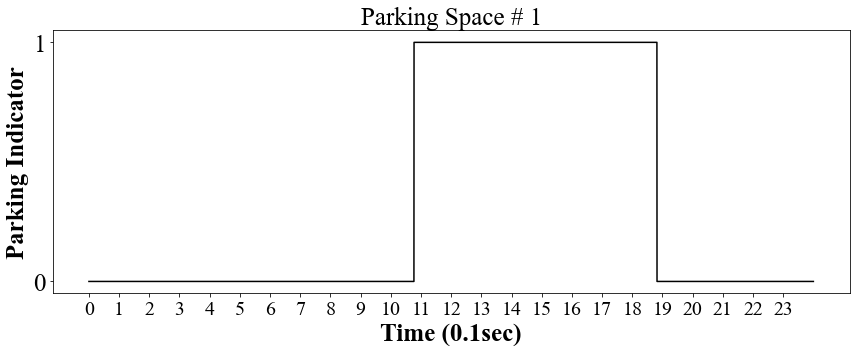

In [180]:
parking_status = np.zeros(48 * 18000)
time_list_temp = time_list[0]
parking_event_temp = parking_events_list[0]
for i in range(len(time_list_temp)):
    for j in range(len(parking_event_temp)):
        t_ind = (time_list_temp[j] - pd.Timestamp(2022,1,22,0,0,0))/(pd.Timedelta(minutes = 30))
        parking_duration = parking_event_temp[j].Occupancy.iloc[0]
        parking_end =  parking_event_temp[j].Ends.iloc[0]
        parking_start = parking_event_temp[j].Starts.iloc[0]
        if parking_end > 17700:
            parking_end = 18000
        parking_status[int(t_ind * 18000 + parking_start): int(t_ind * 18000 + parking_end)] = 1
        
plt.figure(figsize=(12,5))
plt.plot(parking_status, c = 'black')
plt.title('Parking Space # 1',fontsize = 25)
plt.yticks([0,1],fontsize = 25)
plt.ylabel('Parking Indicator',fontsize = 25, fontweight = 'bold')
plt.xticks(np.arange(0,48 * 18000,36000),np.arange(24),fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\Parking1_22.tif',dpi = 300)
plt.show()
counts,appears = count(parking_status == 1)
parking_events = []
for i,a in enumerate(appears):
    hour = (a/(18000 * 48))*24
    begin_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    hour = ((a + counts[i])/(18000 * 48))*24
    end_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    duration = (counts[i]/36000) * 60
    parking_events.append([begin_ts,duration,end_ts])
info = pd.DataFrame(parking_events,columns=['Begin_ts','Duration (min)','End_ts'])

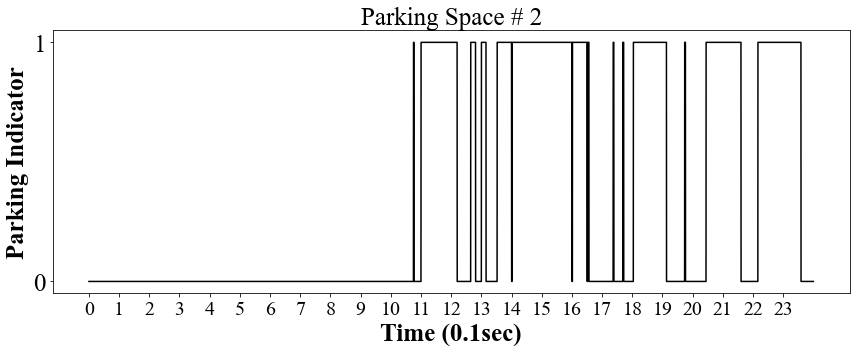

In [185]:
parking_status = np.zeros(48 * 18000)
time_list_temp = time_list[1]
parking_event_temp = parking_events_list[1]
for i in range(len(time_list_temp)):
    for j in range(len(parking_event_temp)):
        t_ind = (time_list_temp[j] - pd.Timestamp(2022,1,22,0,0,0))/(pd.Timedelta(minutes = 30))
        parking_duration = parking_event_temp[j].Occupancy.iloc[0]
        parking_end =  parking_event_temp[j].Ends.iloc[0]
        parking_start = parking_event_temp[j].Starts.iloc[0]
        if parking_end > 17700:
            parking_end = 18000
        parking_status[int(t_ind * 18000 + parking_start): int(t_ind * 18000 + parking_end)] = 1
        
        
plt.figure(figsize=(12,5))
plt.plot(parking_status, c = 'black')
plt.title('Parking Space # 2',fontsize = 25)

plt.yticks([0,1],fontsize = 25)
plt.ylabel('Parking Indicator',fontsize = 25, fontweight = 'bold')
plt.xticks(np.arange(0,48 * 18000,36000),np.arange(24),fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\Parking2_22.tif',dpi = 300)

plt.show()
counts,appears = count(parking_status == 1)
parking_events = []
for i,a in enumerate(appears):
    hour = (a/(18000 * 48))*24
    begin_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    hour = ((a + counts[i])/(18000 * 48))*24
    end_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    duration = (counts[i]/36000)* 60
    parking_events.append([begin_ts,duration,end_ts])
info = pd.DataFrame(parking_events,columns=['Begin_ts','Duration (min)','End_ts'])

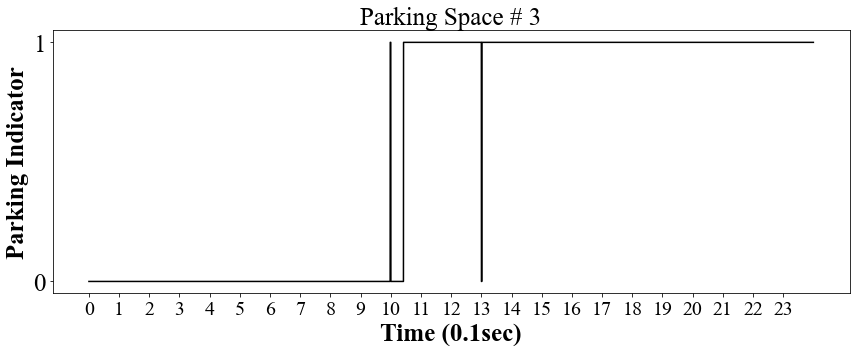

In [189]:
parking_status = np.zeros(48 * 18000)
time_list_temp = time_list[2]
parking_event_temp = parking_events_list[2]
for i in range(len(time_list_temp)):
    for j in range(len(parking_event_temp)):
        t_ind = (time_list_temp[j] - pd.Timestamp(2022,1,22,0,0,0))/(pd.Timedelta(minutes = 30))
        parking_duration = parking_event_temp[j].Occupancy.iloc[0]
        parking_end =  parking_event_temp[j].Ends.iloc[0]
        parking_start = parking_event_temp[j].Starts.iloc[0]
        if parking_end > 17000:
            parking_end = 18000
        parking_status[int(t_ind * 18000 + parking_start): int(t_ind * 18000 + parking_end)] = 1
        
        
plt.figure(figsize=(12,5))
plt.plot(parking_status, c = 'black')
plt.title('Parking Space # 3',fontsize = 25)

plt.yticks([0,1],fontsize = 25)
plt.ylabel('Parking Indicator',fontsize = 25, fontweight = 'bold')
plt.xticks(np.arange(0,48 * 18000,36000),np.arange(24),fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\Parking3_22.tif',dpi = 300)

plt.show()
counts,appears = count(parking_status == 1)
parking_events = []
for i,a in enumerate(appears):
    hour = (a/(18000 * 48))*24
    begin_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    hour = ((a + counts[i])/(18000 * 48))*24
    end_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    duration = (counts[i]/36000 ) * 60
    parking_events.append([begin_ts,duration,end_ts])
pd.DataFrame(parking_events,columns=['Begin_ts','Duration','End_ts'])
info = pd.DataFrame(parking_events,columns=['Begin_ts','Duration (min)','End_ts'])

In [175]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\DATA\Larue24'
dir_list = os.listdir(f_path)
time_list = []
parking_events_list = []
for i in range(3):
    time = []
    parking_events = []
    for p in dir_list:
        t = p.split('.')[0]
        Year,Month,Day,Hour,Minitue,Second = np.array(t.split('-'))
        Second,Parking_ind = Second.split('_')
        Parking_ind = eval(Parking_ind)
        if Parking_ind == i:
            time.append(pd.Timestamp(eval(Year),eval(Month),eval(Day),eval(Hour),eval(Minitue),eval(Second)))
            parking_events.append(pd.read_csv(os.path.join(f_path,p)))
    parking_events_list.append(parking_events)
    time_list.append(time)
# ts_ind = pd.Series(time).argsort().values
# ts = pd.Series(time).sort_values()
# parking_event_list = np.array(parking_event_list)[pd.Series(time).argsort().values]

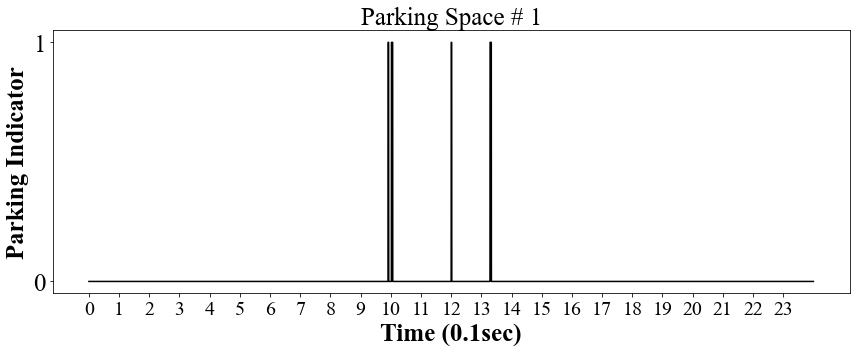

In [176]:
parking_status = np.zeros(48 * 18000)
time_list_temp = time_list[0]
parking_event_temp = parking_events_list[0]
for i in range(len(time_list_temp)):
    for j in range(len(parking_event_temp)):
        t_ind = (time_list_temp[j] - pd.Timestamp(2022,1,24,0,0,0))/(pd.Timedelta(minutes = 30))
        parking_duration = parking_event_temp[j].Occupancy.iloc[0]
        parking_end =  parking_event_temp[j].Ends.iloc[0]
        parking_start = parking_event_temp[j].Starts.iloc[0]
        if parking_end > 17700:
            parking_end = 18000
        parking_status[int(t_ind * 18000 + parking_start): int(t_ind * 18000 + parking_end)] = 1
        
plt.figure(figsize=(12,5))
plt.plot(parking_status, c = 'black')
plt.title('Parking Space # 1',fontsize = 25)
plt.yticks([0,1],fontsize = 25)
plt.ylabel('Parking Indicator',fontsize = 25, fontweight = 'bold')
plt.xticks(np.arange(0,48 * 18000,36000),np.arange(24),fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\Parking1_24.tif',dpi = 300)
plt.show()
counts,appears = count(parking_status == 1)
parking_events = []
for i,a in enumerate(appears):
    hour = (a/(18000 * 48))*24
    begin_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    hour = ((a + counts[i])/(18000 * 48))*24
    end_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    duration = (counts[i]/36000) * 60
    parking_events.append([begin_ts,duration,end_ts])
info = pd.DataFrame(parking_events,columns=['Begin_ts','Duration (min)','End_ts'])

In [177]:
info

,Begin_ts,Duration (min),End_ts
0,2022-01-22 09:54:30.900,1.206667,2022-01-22 09:55:43.300
1,2022-01-22 10:01:06.800,2.628333,2022-01-22 10:03:44.500
2,2022-01-22 12:00:00.000,1.085000,2022-01-22 12:01:05.100
3,2022-01-22 13:17:10.100,2.638333,2022-01-22 13:19:48.400


In [153]:
info.loc[:,['Duration (min)']].mean()

Duration (min)    1.889583
dtype: float64

In [152]:
info.loc[:,['Duration (min)']].sum()/(24*60)*100

Duration (min)    0.524884
dtype: float64

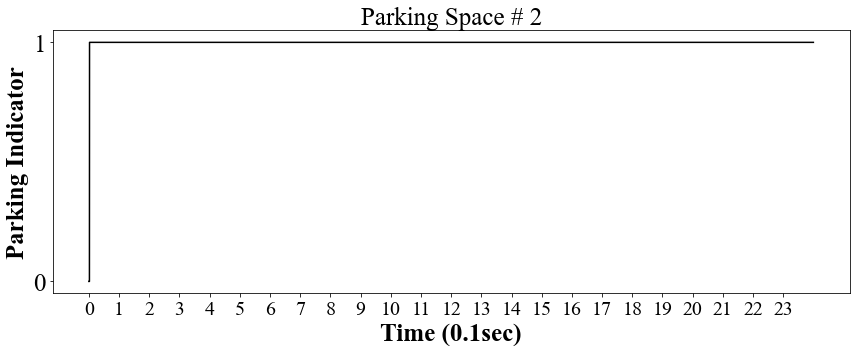

In [154]:
parking_status = np.zeros(48 * 18000)
time_list_temp = time_list[1]
parking_event_temp = parking_events_list[1]
for i in range(len(time_list_temp)):
    for j in range(len(parking_event_temp)):
        t_ind = (time_list_temp[j] - pd.Timestamp(2022,1,24,0,0,0))/(pd.Timedelta(minutes = 30))
        parking_duration = parking_event_temp[j].Occupancy.iloc[0]
        parking_end =  parking_event_temp[j].Ends.iloc[0]
        parking_start = parking_event_temp[j].Starts.iloc[0]
        if parking_end > 17700:
            parking_end = 18000
        parking_status[int(t_ind * 18000 + parking_start): int(t_ind * 18000 + parking_end)] = 1
        
plt.figure(figsize=(12,5))
plt.plot(parking_status, c = 'black')
plt.title('Parking Space # 2',fontsize = 25)
plt.yticks([0,1],fontsize = 25)
plt.ylabel('Parking Indicator',fontsize = 25, fontweight = 'bold')
plt.xticks(np.arange(0,48 * 18000,36000),np.arange(24),fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\Parking2_24.tif',dpi = 300)
plt.show()
counts,appears = count(parking_status == 1)
parking_events = []
for i,a in enumerate(appears):
    hour = (a/(18000 * 48))*24
    begin_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    hour = ((a + counts[i])/(18000 * 48))*24
    end_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    duration = (counts[i]/36000) * 60
    parking_events.append([begin_ts,duration,end_ts])
info = pd.DataFrame(parking_events,columns=['Begin_ts','Duration (min)','End_ts'])

In [156]:
info.loc[:,['Duration (min)']].sum()/(24*60)*100

Duration (min)    99.93044
dtype: float64

In [155]:
info.loc[:,['Duration (min)']].mean()

Duration (min)    1438.998333
dtype: float64

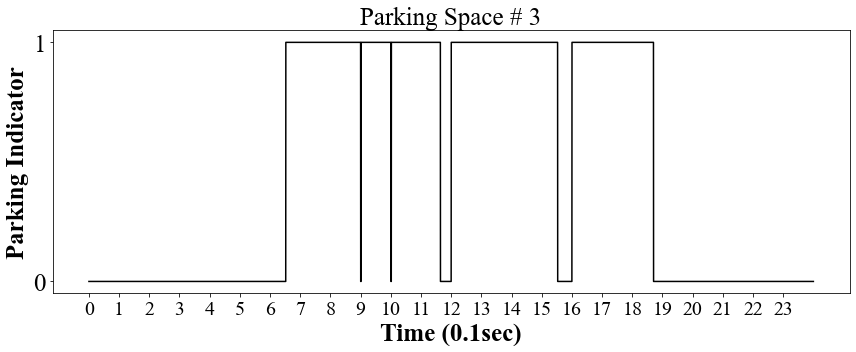

In [157]:
parking_status = np.zeros(48 * 18000)
time_list_temp = time_list[2]
parking_event_temp = parking_events_list[2]
for i in range(len(time_list_temp)):
    for j in range(len(parking_event_temp)):
        t_ind = (time_list_temp[j] - pd.Timestamp(2022,1,24,0,0,0))/(pd.Timedelta(minutes = 30))
        parking_duration = parking_event_temp[j].Occupancy.iloc[0]
        parking_end =  parking_event_temp[j].Ends.iloc[0]
        parking_start = parking_event_temp[j].Starts.iloc[0]
        if parking_end > 17700:
            parking_end = 18000
        parking_status[int(t_ind * 18000 + parking_start): int(t_ind * 18000 + parking_end)] = 1
        
plt.figure(figsize=(12,5))
plt.plot(parking_status, c = 'black')
plt.title('Parking Space # 3',fontsize = 25)
plt.yticks([0,1],fontsize = 25)
plt.ylabel('Parking Indicator',fontsize = 25, fontweight = 'bold')
plt.xticks(np.arange(0,48 * 18000,36000),np.arange(24),fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\2023TRB\FIG\Parking3_24.tif',dpi = 300)
plt.show()
counts,appears = count(parking_status == 1)
parking_events = []
for i,a in enumerate(appears):
    hour = (a/(18000 * 48))*24
    begin_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    hour = ((a + counts[i])/(18000 * 48))*24
    end_ts = pd.Timestamp(2022,1,22,0,0,0) + pd.Timedelta(hours = hour)
    duration = (counts[i]/36000) * 60
    parking_events.append([begin_ts,duration,end_ts])
info = pd.DataFrame(parking_events,columns=['Begin_ts','Duration (min)','End_ts'])